In [62]:
# Importing the "warnings" module and sets a filter to ignore FutureWarnings. The action is set to 'ignore'
import warnings
warnings.filterwarnings(action='ignore') #, category=FutureWarning

In [63]:
# Importing Pandas Modules
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from sklearn.metrics import confusion_matrix #Functions for evaluating the performance of machine learning models
from sklearn.metrics import accuracy_score
from sklearn.metrics import brier_score_loss
from google.colab import drive
import matplotlib.pyplot as plt #For creating visualizations in Python
#!pip install scikit-learn==1.0.1

In [64]:
#mount the Google Drive to the Colaboratory runtime
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Acquisition and Preprocessing**

In [65]:
#Reading the features file
df_events=pd.read_csv("/content/drive/MyDrive/Stat Stars/features.csv")

In [66]:
#Dropping unwanted columns from the Dataset
df_events.drop(['game_id','action_id'],axis='columns', inplace=True)

In [67]:
#Reading the Labels file
df_results =pd.read_csv("/content/drive/MyDrive/Stat Stars/labels.csv")

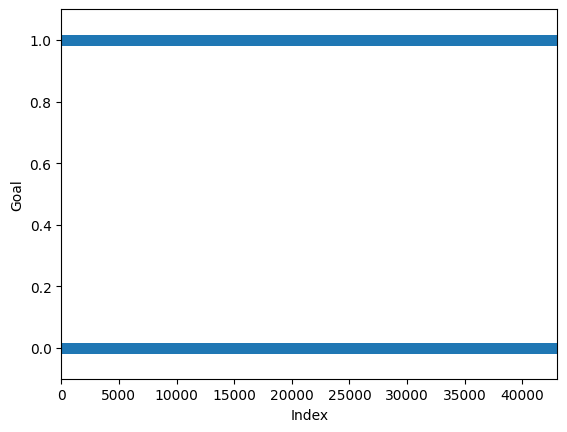

In [68]:
import matplotlib.pyplot as plt
import pandas as pd
# create a scatter plot
plt.scatter(x=range(len(df_results)), y=df_results['goal'].astype(int))

# set the x-axis label
plt.xlabel('Index')

# set the y-axis label
plt.ylabel('Goal')

# set the limits of the x-axis and y-axis
plt.xlim(0, len(df_results))
plt.ylim(-0.1, 1.1)

# display the plot
plt.show()

<Axes: >

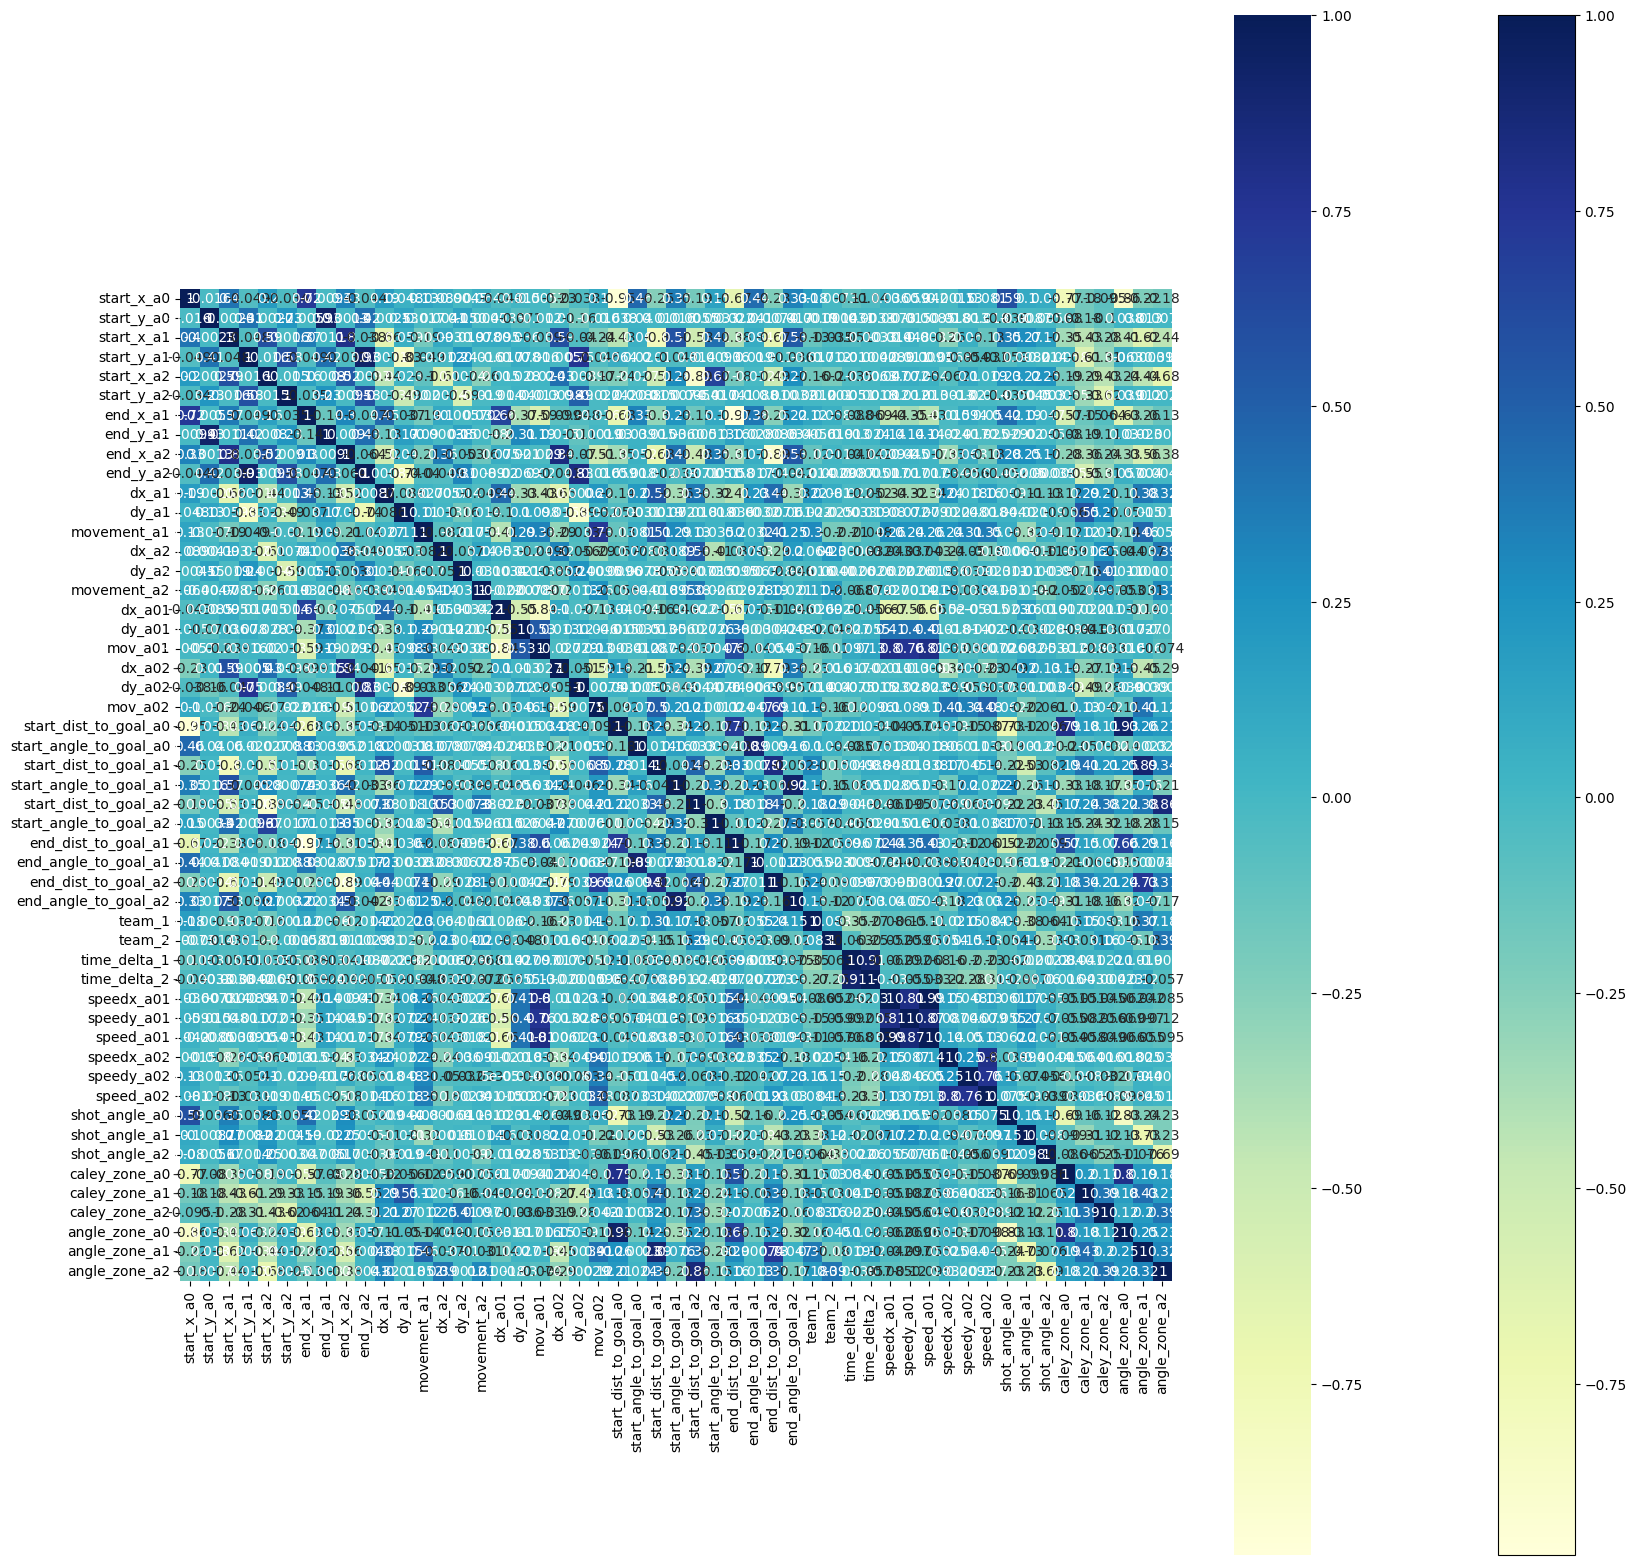

In [69]:
import pandas as pd
import seaborn as sns

# create a correlation matrix
corr_matrix = df_events.corr()

fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(corr_matrix, cmap='YlGnBu')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# plot the correlation matrix using seaborn
sns.heatmap(corr_matrix, cmap='YlGnBu', annot=True)

In [70]:
# To see the Imbalance in the Label Dataset of Goal and No Goal
# Get the count of each unique value in the 'goal' column
goal_counts = df_results['goal'].value_counts()

# Print the goal counts and percentage
total_samples = goal_counts.sum()
print(goal_counts)
print("Initially there is a class imbalance with goal- {:.1f}% and no goal- {:.1f}%".format(goal_counts[1]/total_samples*100, goal_counts[0]/total_samples*100))
print("Goal: {} ({:.2f}%)".format(goal_counts[1], (goal_counts[1]/goal_counts.sum())*100)) #percentage of samples that have the goal label.
print("No goal: {} ({:.2f}%)".format(goal_counts[0], (goal_counts[0]/goal_counts.sum())*100)) #percentage of samples that have the No goal label.

False    38250
True      4790
Name: goal, dtype: int64
Initially there is a class imbalance with goal- 11.1% and no goal- 88.9%
Goal: 4790 (11.13%)
No goal: 38250 (88.87%)


# **One Hot Encoding (Making dummies for Categorical variables)**
One hot encoding or making dummies for categorical variables is a technique used to convert categorical variables into a numerical format that can be easily understood by machine learning models.

In [71]:
# 3 New Dataframes for storing data
#The first new dataframe df_events1s contains columns related to the first player involved in the event
#The second new dataframe df_events2s contains columns related to both players involved in the event
#The third new dataframe df_events3s is simply a copy of the original dataframe
#Finally, the code creates a fourth new dataframe df_basic by selecting a subset of columns from the df_events1s dataframe
df_events1s = df_events[['type_id_a0','bodypart_id_a0','start_x_a0', 'start_y_a0',\
                         'start_dist_to_goal_a0', 'start_angle_to_goal_a0',\
                         'shot_angle_a0','caley_zone_a0','angle_zone_a0']].copy()
df_events2s = df_events[['type_id_a0', 'type_id_a1','bodypart_id_a0','bodypart_id_a1','result_id_a1',\
                         'start_x_a0', 'start_y_a0', 'start_x_a1', 'start_y_a1','end_x_a1', 'end_y_a1',\
                         'dx_a1','dy_a1', 'movement_a1', 'dx_a01','dy_a01', 'mov_a01',\
                         'start_dist_to_goal_a0', 'start_angle_to_goal_a0',\
                         'start_dist_to_goal_a1', 'start_angle_to_goal_a1',\
                         'end_dist_to_goal_a1', 'end_angle_to_goal_a1',\
                         'team_1',  'time_delta_1',\
                         'speedx_a01', 'speedy_a01', 'speed_a01',  'shot_angle_a0', 'shot_angle_a1',\
                         'caley_zone_a0', 'caley_zone_a1','angle_zone_a0', 'angle_zone_a1']].copy()
df_events3s = df_events.copy()
df_basic = df_events1s[['type_id_a0','bodypart_id_a0','start_x_a0', 'start_y_a0',\
                         'start_dist_to_goal_a0','shot_angle_a0']].copy()

Based on the new dataframes created, we are trying to extract features that might be useful in predicting whether a shot in an event results in a goal or not. The features extracted include the type of event, the body part used in the shot, the location of the shot, the distance and angle to the goal at the start of the shot, and the shot angle.

By extracting these features and encoding them using one-hot encoding, we are preparing the data for a machine learning model that can learn to predict the outcome of a shot based on these features.**This could potentially be useful in analyzing and improving a team's performance by identifying factors that contribute to successful shots and goals.**

**In the below Python Code**: 'create_dummies' function is using one hot encoding to convert categorical variables into binary features. 
'data' as input and an optional argument 'nshots' which specifies the number of shots in the data. 
The function checks the value of nshots and creates binary features for categorical variables in the 'data' based on the specified number of shots. 

*   If **nshots=0**, it creates binary features for type_id_a0 and bodypart_id_a0. 
*   If **nshots=1**, it creates binary features for caley_zone_a0, angle_zone_a0, type_id_a1, bodypart_id_a1, and result_id_a1.
*   If **nshots=2**, it creates binary features for caley_zone_a2, angle_zone_a2, type_id_a2, bodypart_id_a2, and result_id_a2.

The function then joins the binary features to the data DataFrame, drops the original categorical variables, and returns the modified DataFrame with binary features as new columns.

In [72]:
def create_dummies(data,nshots=0):
    if (nshots>=0):
        data_dummies = pd.get_dummies(data.type_id_a0,prefix="type_id_a0")
        data = data.join(data_dummies)
        data=data.drop(columns=["type_id_a0"])
        data_dummies = pd.get_dummies(data.bodypart_id_a0,prefix="bodypart_id_a0")  
        data = data.join(data_dummies)
        data=data.drop(columns=["bodypart_id_a0"]) 
    if (nshots>=1):
        data_dummies = pd.get_dummies(data.caley_zone_a0,prefix="caley_zone_a0") 
        data = data.join(data_dummies)
        data=data.drop(columns=["caley_zone_a0"]) 
        data_dummies = pd.get_dummies(data.angle_zone_a0,prefix="angle_zone_a0") 
        data = data.join(data_dummies)
        data=data.drop(columns=["angle_zone_a0"]) 
    if (nshots>=2):
        data_dummies = pd.get_dummies(data.type_id_a1,prefix="type_id_a1")
        data = data.join(data_dummies)
        data=data.drop(columns=["type_id_a1"]) 
        data_dummies = pd.get_dummies(data.bodypart_id_a1,prefix="bodypart_id_a1") 
        data = data.join(data_dummies)
        data=data.drop(columns=["bodypart_id_a1"]) 
        data_dummies = pd.get_dummies(data.caley_zone_a1,prefix="caley_zone_a1") 
        data = data.join(data_dummies)
        data=data.drop(columns=["caley_zone_a1"]) 
        data_dummies = pd.get_dummies(data.angle_zone_a1,prefix="angle_zone_a1") 
        data = data.join(data_dummies)
        data=data.drop(columns=["angle_zone_a1"]) 
        data_dummies = pd.get_dummies(data.result_id_a1,prefix="result_id_a1") # 1- open play, 2- set piece, 3- corner, 4- free kick
        data = data.join(data_dummies)
        data=data.drop(columns=["result_id_a1"]) 
        data=data.drop(columns=["result_id_a1_fail"])
        data_dummies = pd.get_dummies(data.team_1,prefix="team_1") # 1- open play, 2- set piece, 3- corner, 4- free kick
        data = data.join(data_dummies)
        data=data.drop(columns=["team_1"])
        data_dummies = pd.get_dummies(data.team_2,prefix="team_2") # 1- open play, 2- set piece, 3- corner, 4- free kick
        data = data.join(data_dummies)
        data=data.drop(columns=["team_2"])
        data=data.drop(columns=["team_1_False"])
        data=data.drop(columns=["team_2_False"])

    if (nshots==3):
        data_dummies = pd.get_dummies(data.type_id_a2,prefix="type_id_a2")
        data = data.join(data_dummies)
        data=data.drop(columns=["type_id_a2"])
        data_dummies = pd.get_dummies(data.bodypart_id_a2,prefix="bodypart_id_a2") 
        data = data.join(data_dummies)
        data=data.drop(columns=["bodypart_id_a2"]) 
        data_dummies = pd.get_dummies(data.caley_zone_a2,prefix="caley_zone_a2") 
        data = data.join(data_dummies)
        data=data.drop(columns=["caley_zone_a2"]) 
        data_dummies = pd.get_dummies(data.angle_zone_a2,prefix="angle_zone_a2") 
        data = data.join(data_dummies)
        data=data.drop(columns=["angle_zone_a2"]) 
        data_dummies = pd.get_dummies(data.result_id_a2,prefix="result_id_a2") # 1- open play, 2- set piece, 3- corner, 4- free kick
        data = data.join(data_dummies)
        data=data.drop(columns=["result_id_a2"])     
    return data

In [73]:
#df_events_2
df_events_2=df_events
df_events_2=create_dummies(df_events_2,nshots=3)

Both above set of codes are performing one-hot encoding. The First code defines a function called create_dummies that takes in a dataframe data and performs one-hot encoding on some of its categorical columns based on the value of the nshots parameter. The second code is simply applying the create_dummies function on a dataframe called df_events_2, which creates new columns of binary values (1's and 0's) for each unique value of the categorical columns.

# **TOMEKLINKS**

In [74]:
from imblearn.under_sampling import TomekLinks
y = df_results['goal']
# Create an instance of the TomekLinks class
tl = TomekLinks()

# Resample the data using Tomek Links undersampling
X_resampled, y_resampled = tl.fit_resample(df_events_2, y)

In [75]:
print('original dataset shape:', y.shape)
print('Resample dataset shape', y_resampled.shape)
print(pd.Series(y_resampled).value_counts())

original dataset shape: (43040,)
Resample dataset shape (41347,)
False    36557
True      4790
Name: goal, dtype: int64


# **OneSidedSelection**

In [76]:
from imblearn.under_sampling import OneSidedSelection

oss = OneSidedSelection(random_state=42)
X_resampled_oss, y_resampled_oss = oss.fit_resample(df_events_2, y)

In [77]:
print('original dataset shape:', y.shape)
print('Resample dataset shape', y_resampled_oss.shape)
print(pd.Series(y_resampled_oss).value_counts())

original dataset shape: (43040,)
Resample dataset shape (41341,)
False    36551
True      4790
Name: goal, dtype: int64


# **NearMiss**

In [78]:
from imblearn.under_sampling import NearMiss
from sklearn.datasets import make_classification
from collections import Counter

# generate a binary classification dataset
# X, y = make_classification(n_samples=10000, n_features=20, n_informative=10, n_redundant=10, n_classes=2, random_state=42)

# summarize the original class distribution
print('Original Dataset Shape:', Counter(y))

# define the undersampling method
undersample = NearMiss(version=2)

# transform the dataset
X_resampled_nm, y_resampled_nm = undersample.fit_resample(df_events_2, y)

# summarize the class distribution after applying undersampling
print('Undersampled Dataset Shape:', Counter(y_resampled_nm))

Original Dataset Shape: Counter({False: 38250, True: 4790})
Undersampled Dataset Shape: Counter({False: 4790, True: 4790})


# **Random Undersampling with IMBLearn**
* Random under-sampling is a technique used in machine learning to deal with imbalanced datasets. Imbalanced datasets are datasets where the number of instances in one class is much higher than the other class. This can lead to biased results when training a machine learning model.
* Random under-sampling involves reducing the number of instances in the majority class by randomly selecting a subset of instances equal to the number of instances in the minority class. This can be done using the imblearn library in Python.

In [79]:
!pip install -U scikit-learn
from imblearn.under_sampling import RandomUnderSampler
y = df_results['goal']
rus = RandomUnderSampler(random_state=42, replacement=True, sampling_strategy=0.2395) #Initializes a RandomUnderSampler object called "rus"
x_rus, y_rus = rus.fit_resample(df_events_2, y)# fit predictor and target variable
print('original dataset shape:', y.shape)
print('Resample dataset shape', y_rus.shape)
print(pd.Series(y_rus).value_counts())
#The resulting undersampled predictor and target variables are stored in x_rus and y_rus, respectively.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
original dataset shape: (43040,)
Resample dataset shape (24790,)
False    20000
True      4790
Name: goal, dtype: int64


## **Synthetic Minority Oversampling Technique (SMOTE)**

SMOTE (Synthetic Minority Oversampling Technique) works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.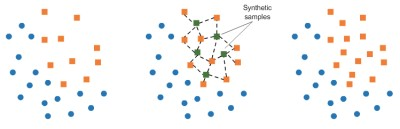

In [80]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=0.5) #Indicates that the minority class is oversampled to achieve a ratio of 0.5 between the majority and minority classes.
#Fit predictor and target variable
x_smote, y_smote = smote.fit_resample(x_rus, y_rus)#fit_resample()-fit the predictor and target variables, x_rus and y_rus respectively. 
print('Original dataset shape', y_rus.shape)
print('Resample dataset shape', y_smote.shape)
print(pd.Series(y_smote).value_counts())
df_shots=x_smote #df_shots and y variables are updated to use the oversampled data
y=y_smote

Original dataset shape (24790,)
Resample dataset shape (30000,)
False    20000
True     10000
Name: goal, dtype: int64


**Explaination of the overall approach:** 


* The Random Under-Sampling (RUS) technique is applied to the original dataset 'df_events_2' and 'y'. RUS randomly removes samples from the majority class until both classes become balanced or reach the specified sampling strategy.
* After RUS, the number of samples in both classes will be more balanced, but the dataset might be still insufficient to train a good classification model.  
* To address this, the SMOTE (Synthetic Minority Over-sampling Technique) algorithm is applied on the under-sampled dataset. SMOTE generates synthetic samples for the minority class to increase its representation in the dataset, with the aim of making the dataset more suitable for training a classification model. The oversampled data is stored in x_smote and y_smote. 
* In summary, the code first performs random under-sampling on the original dataset to remove some of the majority class samples, making the classes more balanced. Then, it applies SMOTE to the under-sampled dataset to generate synthetic minority class samples, increasing the number of samples in the dataset.



 



# **Feature Scaling(Normalization)**
This can help to improve the performance of some machine learning algorithms, particularly those that are sensitive to differences in the scales of the input features. Necessary when different features are measured in different units or scales.
To bring all the features/variables to a similar scale, as different features may have different ranges of values. If we do not scale the features, the features with larger values will dominate and have a greater effect on the final results

In [81]:
# df_shots=df_events_2.to_numpy()
#Feature scaling on the df_shots dataset using the StandardScaler() method from the sklearn.preprocessing module
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(df_shots) #compute the mean and standard deviation of each feature
df_shots = scaler.transform(df_shots) #transform the dataset to have zero mean and unit variance

# **Splitting the Data into Train-Test-Validation sets (70/30)**

In [82]:
#20% Testing Data and 80% Training Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_shots, y, test_size=0.2, random_state=1)
#Validation Set Test Size: 25% from Training Data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# **Visualising the data with on a 3-d plot with PCA to reduce dimensions to 3**

PCA is performed with a pre-defined number of components, which is set to 3. This means that the number of principal components is fixed and determined beforehand. By reducing the dimensionality of the data, PCA can help identify the underlying structure of the data in a way that is more interpretable and less prone to overfitting.
 It does this by identifying the principal components, which are linear combinations of the original variables that explain the largest amount of variation in the data. These principal components are then used to project the data onto a lower-dimensional space, reducing the number of features while still preserving much of the original information.

In [83]:
#PCA Application to Reduce the dimension to 3
from sklearn.decomposition import PCA
pca = PCA(n_components=3) # We want to lose maximum of 10% information by PCA, will reduce dimensions accordingly.
X_pca = pca.fit_transform(X_train)
print(pca.explained_variance_ratio_) #explained variance ratio of the principal components
result=pd.DataFrame(X_pca, columns=['PCA%i' % i for i in range(3)]) #A new dataframe result is created from X_pca, with columns labeled PCA0, PCA1, and PCA2

[0.07837573 0.05368004 0.04444969]


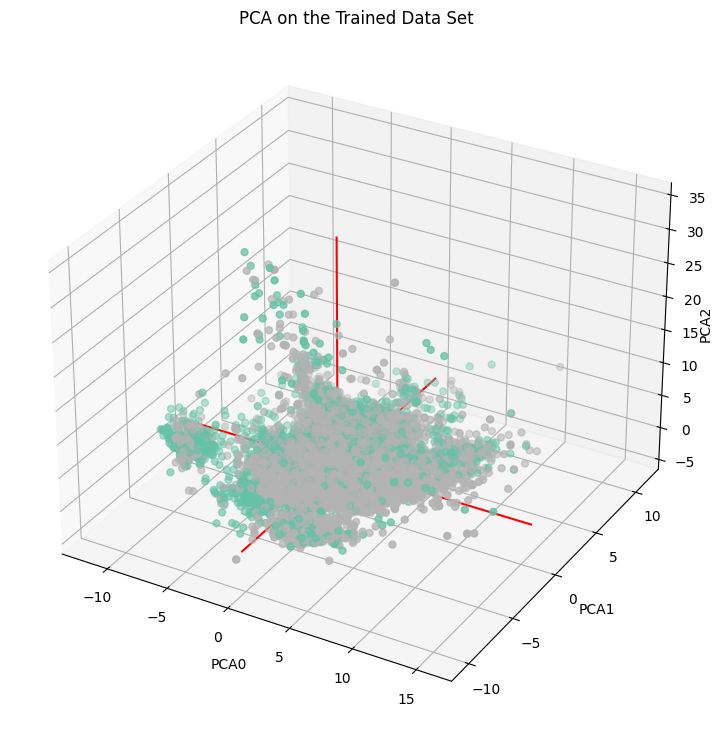

In [84]:
# Figure to visualize the 3-D data after performing PCA for 3 Dimensions
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], c=y_train, cmap="Set2_r", s=25)
xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
ax.set_xlabel("PCA0")
ax.set_ylabel("PCA1")
ax.set_zlabel("PCA2", labelpad=-3, rotation=90)
ax.set_title("PCA on the Trained Data Set")
plt.show()

Now here we want to retain 90% of the variance in the original data. The number of components is determined automatically based on the amount of variance that is retained.

In [85]:
from sklearn.decomposition import PCA
import random
random.seed(0)
pca = PCA(0.9) # We want to lose maximum of 10% information by PCA, will reduce dimensions accordingly. Algorithm should retain enough principal components to explain at least 90% of the variance in the data.
X_train = pca.fit_transform(X_train)
explained_variance = pca.explained_variance_ratio_
print(len(explained_variance),"- Explained Variance that is Retained")
print("By reducing dimensionality from PCA, ",round((1-sum(explained_variance))*100,2),"% information was lost.")
X_val = pca.transform(X_val)
X_test = pca.transform(X_test)
# print(explained_variance)

68 - Explained Variance that is Retained
By reducing dimensionality from PCA,  9.72 % information was lost.


In [86]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import brier_score_loss
import numpy.ma as ma
from matplotlib.ticker import MultipleLocator
from sklearn.metrics import auc, roc_curve
from scipy import integrate
from sklearn.neighbors import KernelDensity

In [87]:
# The function first sets the title and axes labels for the plot, and plots a diagonal line to represent perfect calibration
def plot_calibration_curve(bcc,y_true,y_pred,name='Calibration curve',min_samples=None,axis=None):
    if axis is None:
        axis = plt.figure(figsize=(5, 5)).add_subplot(111)
    axis.set_title(name)
    # plots a diagonal line from (0,0) to (100,100) to represent perfect calibration
    axis.plot([0, 100], [0, 100], ls='--', lw=1, color='grey')
    axis.set_xlabel('Predicted probability')
    axis.set_ylabel('True probability in each bin')
    # Set the x and y axis limits to (0, 100), and specify major and minor tick locators to show ticks at intervals of 20 and 10, respectively
    axis.set_xlim((0, 100))
    axis.xaxis.set_major_locator(MultipleLocator(20))
    axis.xaxis.set_minor_locator(MultipleLocator(10))
    axis.set_ylim((0, 100))
    axis.yaxis.set_major_locator(MultipleLocator(20))
    axis.yaxis.set_minor_locator(MultipleLocator(10))

    # axis.set_aspect(1)
    # Turns on the grid lines for both major and minor ticks
    axis.grid(which='both')
    # Extracts the predicted probabilities, predicted positive percentages, and number of samples used from the bcc input parameter
    sample_probabilities = bcc[0]
    predicted_pos_percents = bcc[1]
    num_plays_used = bcc[2]

# If min_samples is specified, it masks out any bins with fewer than min_samples samples and plots the remaining data in light blue. 
# It then plots the calibration curve using the remaining data in dark blue, along with a legend that displays the area between the curve and the diagonal, 
# and the maximum deviation between the predicted and actual positive percentages.
    
    if min_samples is not None:
        axis.plot(sample_probabilities,predicted_pos_percents,c='c',alpha=0.3) # Plotting sample_probabilities on the x-axis and predicted_pos_percents on the y-axis
        sample_probabilities = ma.array(sample_probabilities)
        sample_probabilities[num_plays_used < min_samples] = ma.masked
        predicted_pos_percents = ma.array(predicted_pos_percents)
        predicted_pos_percents[num_plays_used < min_samples] = ma.masked

    max_deviation = bcc[3]
    residual_area = bcc[4]

    axis.plot(sample_probabilities,predicted_pos_percents,c='c',label='Calibration curve\n(area = %0.2f, max dev = %0.2f)'% (residual_area, max_deviation))
    axis.legend(loc='lower right')

    ax2 = axis.twinx()
    ax2.hist(y_pred * 100,bins=np.arange(0, 101, 1),density=True,alpha=0.4,facecolor='grey')
    ax2.set_ylim([0, 0.2])
    ax2.set_yticks([0, 0.1, 0.2])
    plt.tight_layout()
    return axis

In [88]:
def plot_roc_curve(y_true, y_prob, name='Calibration curve', axis=None):

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    if axis is None:
        axis = plt.figure(figsize=(5, 5)).add_subplot(111)

    axis.plot(fpr, tpr, linewidth=1, label='ROC curve (area = %0.2f)' % roc_auc)

    # reference line, legends, and axis labels
    axis.plot([0, 1], [0, 1], linestyle='--', color='gray')
    axis.set_title('ROC curve')
    axis.set_xlabel('False Positive Rate')
    axis.set_ylabel('True Positive Rate')
    axis.set_xlim(0, 1)
    axis.xaxis.set_major_locator(MultipleLocator(0.20))
    axis.xaxis.set_minor_locator(MultipleLocator(0.10))
    axis.set_ylim(0, 1)
    axis.yaxis.set_major_locator(MultipleLocator(0.20))
    axis.yaxis.set_minor_locator(MultipleLocator(0.10))
    axis.grid(which='both')
    plt.gca().legend()
    axis.legend(loc='lower right')
    plt.tight_layout()

# Decision **Tree**

In [89]:
from sklearn.tree import DecisionTreeClassifier

# Create a decision tree classifier
tree = DecisionTreeClassifier()

# Train the model on the training data
tree.fit(X_train, y_train)

# Make predictions on the test data
y_pred = tree.predict(X_test)

# Evaluate the model

print("Confusion Matrix is: \n",confusion_matrix(y_test, y_pred))
print("Accuracy Score is: \n",accuracy_score(y_test, y_pred))
 # ROC and Brier
roc = roc_auc_score(y_test, y_pred)
brier = brier_score_loss(y_test, y_pred)
print("Brier Score",brier)
print("AUROC",roc)

Confusion Matrix is: 
 [[3259  764]
 [ 712 1265]]
Accuracy Score is: 
 0.754
Brier Score 0.246
AUROC 0.7249751712176986


# RANDOM **FOREST**

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Create a Random Forest model
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rfc.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_rfc = rfc.predict(X_test)

# Evaluate the model's performance
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
cm_rfc = confusion_matrix(y_test, y_pred_rfc)
print(f"Accuracy: {accuracy_rfc}")
print(f"Confusion Matrix: \n{cm_rfc}")

Accuracy: 0.8323333333333334
Confusion Matrix: 
[[3748  275]
 [ 731 1246]]


In [91]:
#!pip install scikit-learn==1.0.1
#!pip install scikit-learn==0.22
#from sklearn.metrics import plot_confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# y_test, y_pred (prob), y_score(Predicted Label)
# y_pred = clf.predict_proba(X_test)
# y_score = clf.predict(X_test)
# model = Trained Model like clf =  LogisticRegression.fit()
# X_test
def run(model,X_test,y_test):
    y_test = np.array(y_test,dtype=bool)
    y_pred = model.predict_proba(X_test)
    y_score = model.predict(X_test)
    
    y_pred = y_pred[:,1] 
    print(y_pred)
    y_pred_bin = np.where(np.array(y_pred) > 0.5, 1, 0)
    
    #Accuracy
    acc = accuracy_score(y_test, y_score)
    cm = confusion_matrix(y_test, y_pred_bin)
  
    print("Confusion Matrix")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    # Confusion Matrix
    #plot_confusion_matrix(model, X_test, y_test)  
    plt.show() 
    
    #PR Graph
    prec, recall, _ = precision_recall_curve(y_test, y_score)
    # pr_display = PrecisionRecallDisplay(precision=prec, recall=recall,average_precision=None, estimator_name=None,clas)    
    # Calibration Curve
    n_bins = 100
    bandwidth = 1 / n_bins

    #Kernel Density Estimation
    kde_pos = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit((y_pred[y_test])[:, np.newaxis])
    kde_total = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(y_pred[:, np.newaxis])
    sample_probabilities = np.linspace(0.01, 0.99, 99)
    # Finding Probability and scaling
    number_density_offense_won = np.exp(kde_pos.score_samples(sample_probabilities[:, np.newaxis])) * np.sum((y_test))
    number_density_total = np.exp(kde_total.score_samples(sample_probabilities[:, np.newaxis])) * len(y_test)
    # Count of Each Bucket
    number_pos = (number_density_offense_won* np.sum(y_test)/ np.sum(number_density_offense_won))
    number_total = (number_density_total * len(y_test) / np.sum(number_density_total))
    # Fraction of goals scored from attempts in each bucket
    predicted_pos_percents = np.nan_to_num(number_pos / number_total, 1)
    #Scaling to 100
    sample_probabilities = 100.0 * sample_probabilities
    predicted_goal_percents = 100.0 * predicted_pos_percents
    num_shots_used = number_total
    # Calculating Deviation and Residual Area
    max_deviation = np.max(np.abs(predicted_goal_percents - sample_probabilities))
    residual_area = integrate.trapz(np.abs(predicted_goal_percents - sample_probabilities),sample_probabilities)
    
    # ROC and Brier
    roc = roc_auc_score(y_test, y_pred)
    brier = brier_score_loss(y_test, y_pred)

    # Gather Everything
    gather = [sample_probabilities,predicted_goal_percents,num_shots_used,max_deviation,residual_area,roc,brier]

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    plot_roc_curve(y_test,y_pred, axis=ax[0])
    plot_calibration_curve(gather,y_test,y_pred,min_samples=100,axis=ax[1],)
    ax[2].grid(which='both')
    ax[2].set_title("Precision-Recall Graph")
    # pr_display.plot(ax=ax[2])
    ax[2].plot(recall,prec)
    print("Accuracy",acc)
    print("AUROC",roc)
    print("Brier Score",brier)
    print("Area of Residual Graph",residual_area)
    print("Maximum Deviation", max_deviation)

In [92]:
import matplotlib.pyplot as plt
#from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#from sklearn.metrics import plot_confusion_matrix
#from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [93]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Create a decision tree classifier
#dt_clf = DecisionTreeClassifier(max_depth=2)

# Create an AdaBoost classifier with 50 estimators
ada_clf_tree = AdaBoostClassifier(base_estimator=tree, n_estimators=50)

# Fit the AdaBoost classifier to your training data
ada_clf_tree.fit(X_train, y_train)
# Make predictions on your test data
y_pred_ada = ada_clf_tree.predict(X_test)
print("Confusion Matrix is: \n",confusion_matrix(y_test, y_pred_ada))
print("Accuracy Score is: \n",accuracy_score(y_test, y_pred_ada))

Confusion Matrix is: 
 [[3316  707]
 [ 716 1261]]
Accuracy Score is: 
 0.7628333333333334


[0. 0. 1. ... 0. 0. 0.]
Confusion Matrix


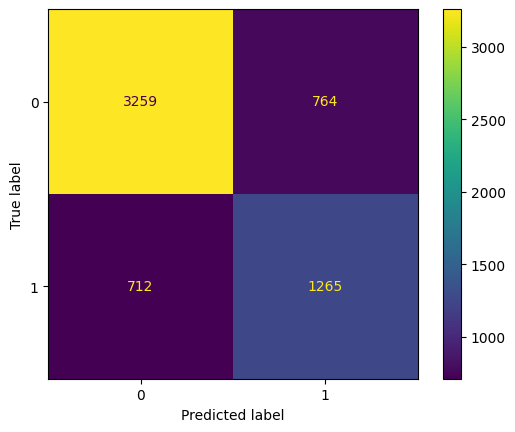

Accuracy 0.754
AUROC 0.7249751712176986
Brier Score 0.246
Area of Residual Graph 2177.032629829446
Maximum Deviation 61.0


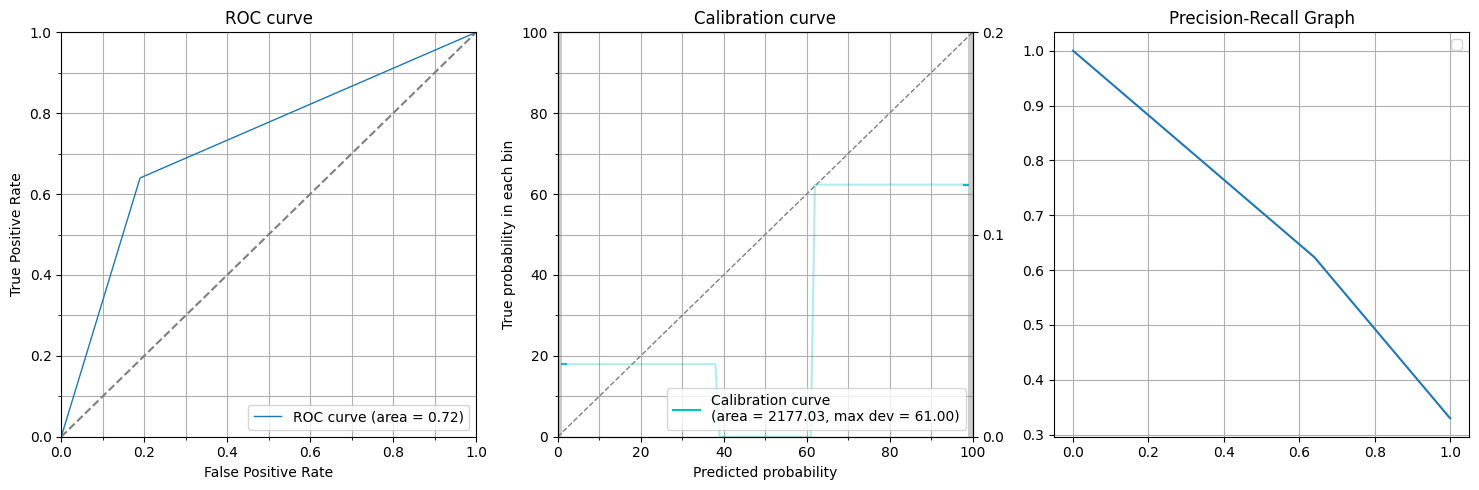

In [94]:
run(tree,X_test,y_test)

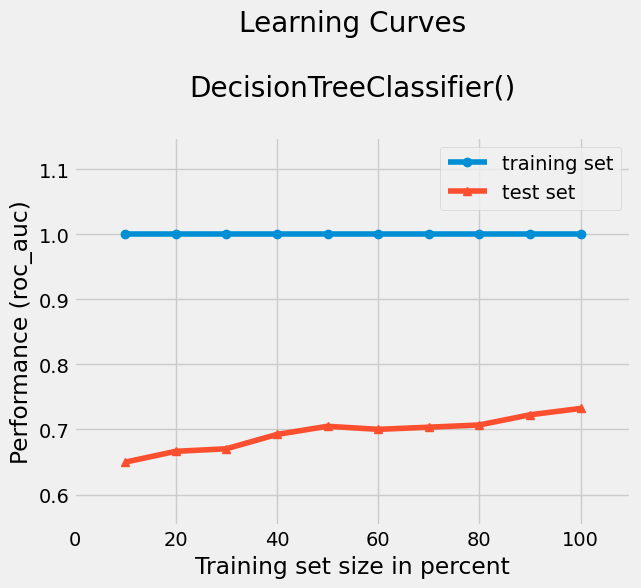

In [95]:
from mlxtend.plotting import plot_learning_curves
plot_learning_curves(X_train, y_train, X_test, y_test, tree,scoring="roc_auc") #{'accuracy', 'average_precision', 'f1_micro', 'f1_macro', 'f1_weighted', 'f1_samples', 'log_loss', 'precision', 'recall', 'roc_auc', 'adjusted_rand_score', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'r2'}
plt.show()

[0.23 0.17 0.88 ... 0.19 0.17 0.23]
Confusion Matrix


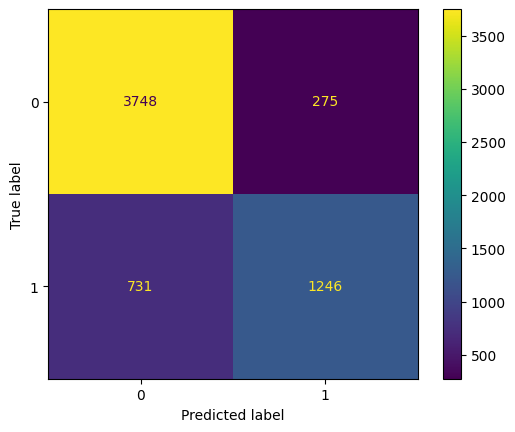

Accuracy 0.8323333333333334
AUROC 0.895111203649325
Brier Score 0.12182728333333334
Area of Residual Graph 680.277240364423
Maximum Deviation 20.019587997797288


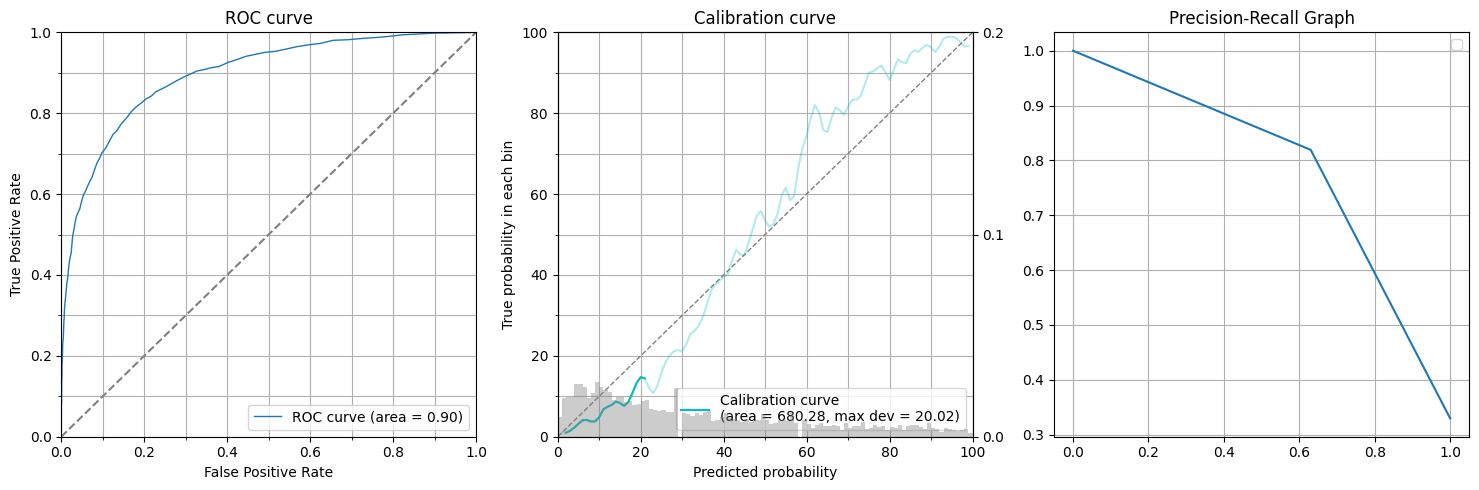

In [96]:
run(rfc,X_test,y_test)

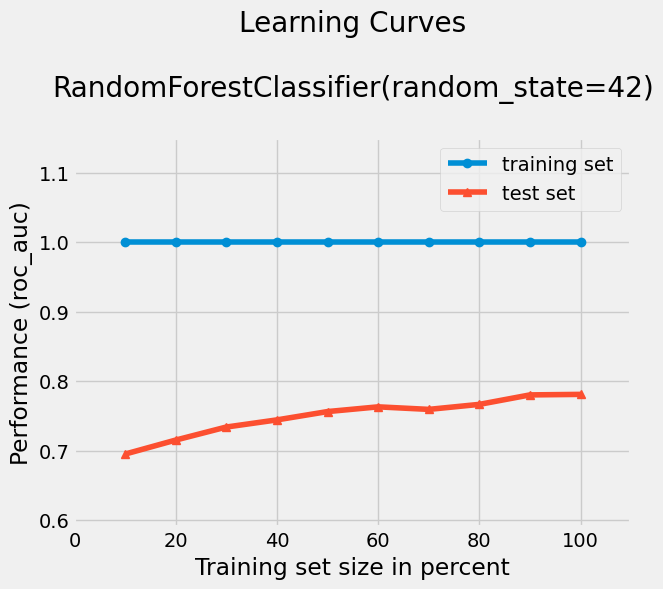

In [97]:
from mlxtend.plotting import plot_learning_curves
plot_learning_curves(X_train, y_train, X_test, y_test,rfc,scoring="roc_auc") #{'accuracy', 'average_precision', 'f1_micro', 'f1_macro', 'f1_weighted', 'f1_samples', 'log_loss', 'precision', 'recall', 'roc_auc', 'adjusted_rand_score', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'r2'}
plt.show()

In [98]:
from sklearn.ensemble import AdaBoostClassifier
clf_abc = AdaBoostClassifier(n_estimators=50, learning_rate=1)
clf_abc.fit(X_train, y_train)
y_pred_abc = clf_abc.predict(X_test)

In [99]:
print(accuracy_score(y_test, y_pred_abc))
print(confusion_matrix(y_test,y_pred_abc))

0.786
[[3548  475]
 [ 809 1168]]


# **ADABoost CLF DEPTH = 5**

In [100]:
from sklearn.ensemble import AdaBoostClassifier
#clf_abc = AdaBoostClassifier(n_estimators=50, learning_rate=1)
clf_dt = DecisionTreeClassifier(max_depth=5)
clf_abc_dt = AdaBoostClassifier(base_estimator=clf_dt, n_estimators=50, learning_rate=1)
clf_abc_dt.fit(X_train, y_train)
y_pred_abc_dt = clf_abc_dt.predict(X_test)
print(accuracy_score(y_test, y_pred_abc_dt))
print(confusion_matrix(y_test,y_pred_abc_dt))

0.8085
[[3549  474]
 [ 675 1302]]


# **ADABoost CLF DEPTH = 10**


In [101]:
from sklearn.ensemble import AdaBoostClassifier
#clf_abc = AdaBoostClassifier(n_estimators=50, learning_rate=1)
clf_dt_ten = DecisionTreeClassifier(max_depth=10)
clf_abc_dt_ten = AdaBoostClassifier(base_estimator=clf_dt_ten, n_estimators=50, learning_rate=1)
clf_abc_dt_ten.fit(X_train, y_train)
y_pred_abc_dt_ten = clf_abc_dt_ten.predict(X_test)
print(accuracy_score(y_test, y_pred_abc_dt_ten))
print(confusion_matrix(y_test,y_pred_abc_dt_ten))

0.8176666666666667
[[3676  347]
 [ 747 1230]]


[0.49599292 0.50253269 0.50312635 ... 0.48580487 0.50368088 0.49150862]
Confusion Matrix


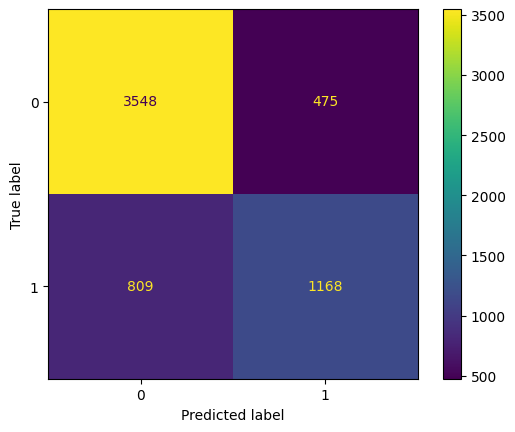

Accuracy 0.786
AUROC 0.8228514946493173
Brier Score 0.24441994395322036
Area of Residual Graph 2992.542569688876
Maximum Deviation 99.0


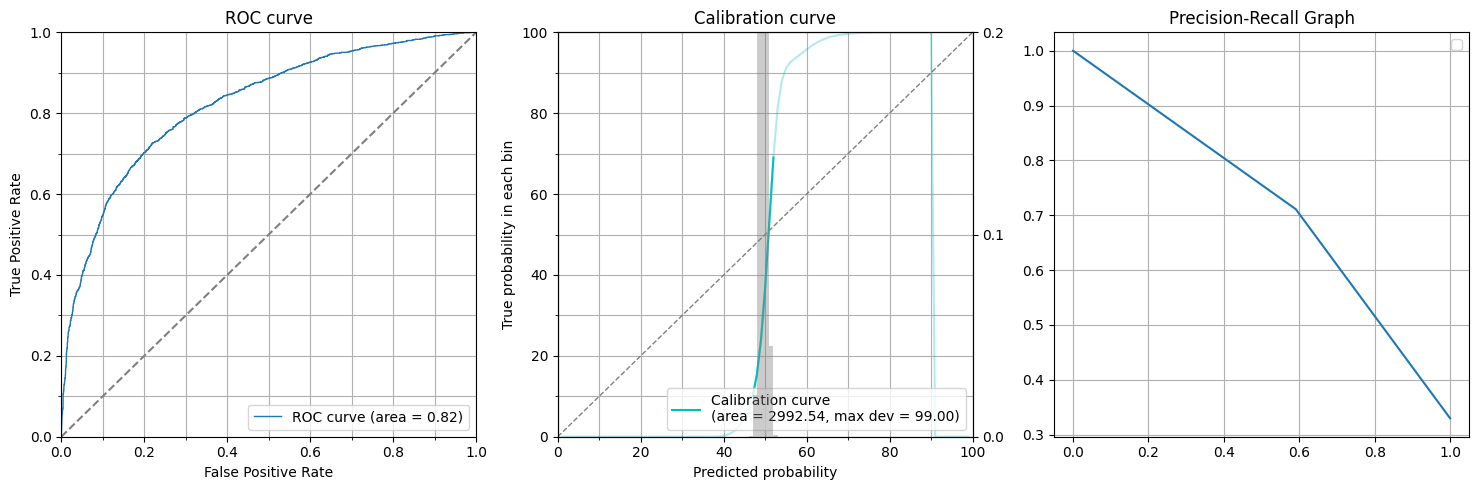

In [102]:
run(clf_abc,X_test,y_test) # ADA Boost Classifier

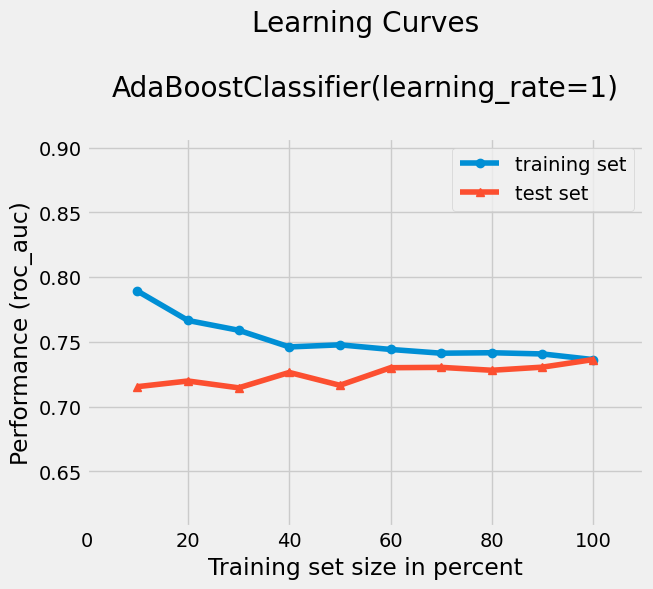

In [103]:
from mlxtend.plotting import plot_learning_curves
plot_learning_curves(X_train, y_train, X_test, y_test, clf_abc,scoring="roc_auc") #{'accuracy', 'average_precision', 'f1_micro', 'f1_macro', 'f1_weighted', 'f1_samples', 'log_loss', 'precision', 'recall', 'roc_auc', 'adjusted_rand_score', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'r2'}
plt.show()

[0.49479672 0.49847239 0.51191958 ... 0.43906387 0.48284057 0.45819883]
Confusion Matrix


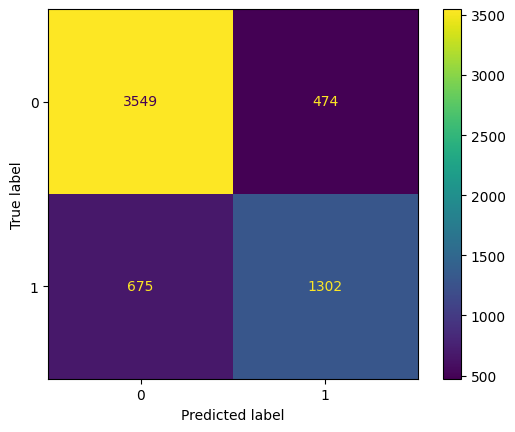

Accuracy 0.8085
AUROC 0.8212499926132879
Brier Score 0.22456754913182894
Area of Residual Graph 1507.9004555261788
Maximum Deviation 40.06209463243457


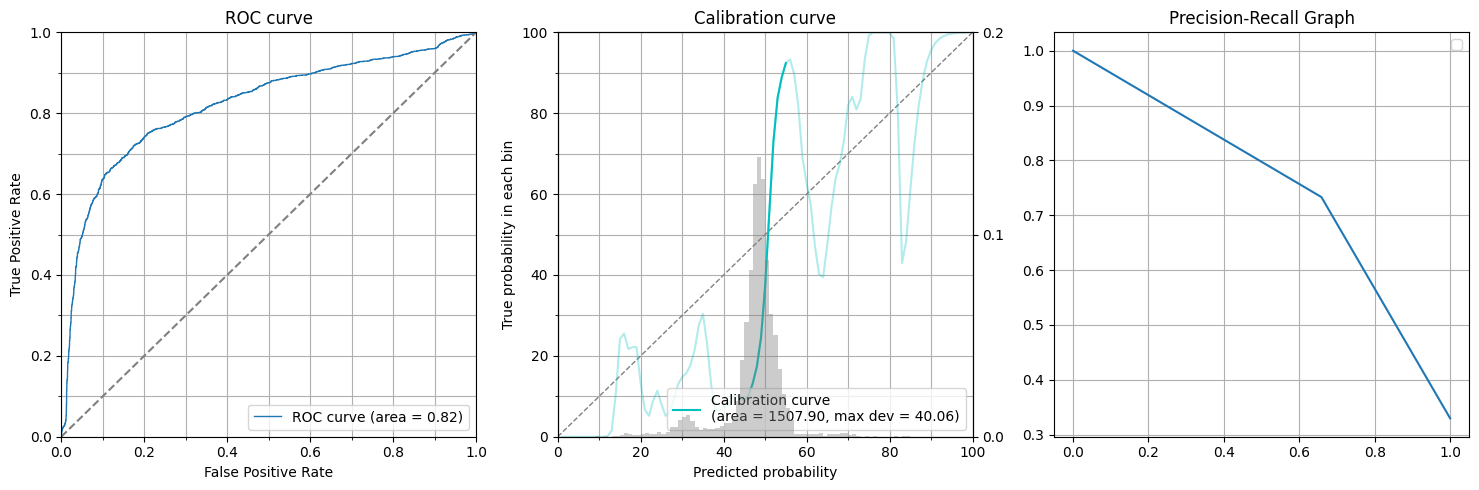

In [104]:
run(clf_abc_dt,X_test,y_test) # ADA Boost Classifier

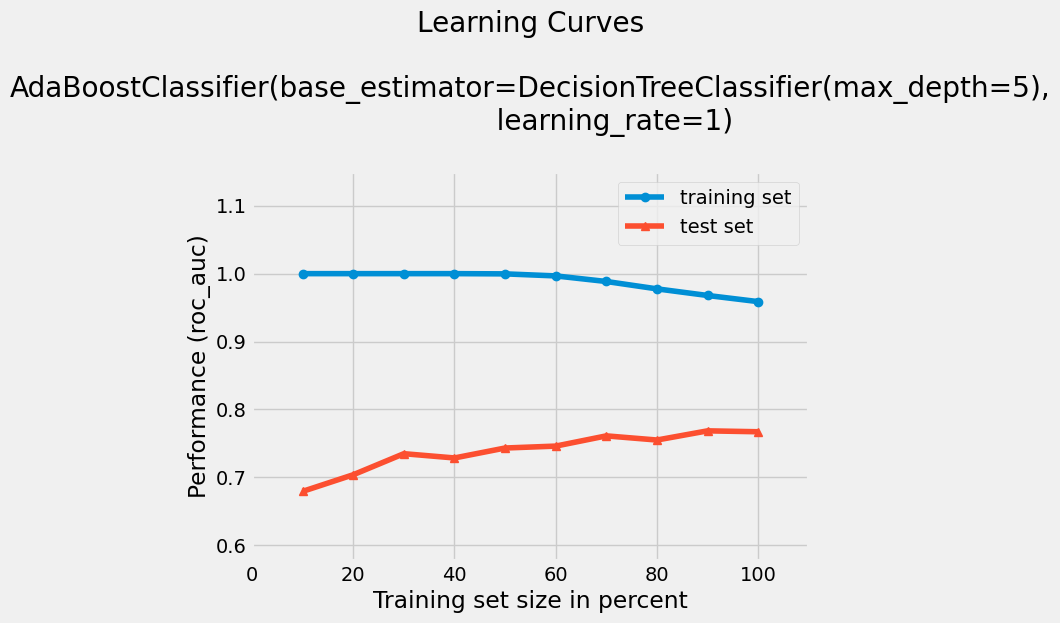

In [105]:
from mlxtend.plotting import plot_learning_curves
plot_learning_curves(X_train, y_train, X_test, y_test, clf_abc_dt,scoring="roc_auc") #{'accuracy', 'average_precision', 'f1_micro', 'f1_macro', 'f1_weighted', 'f1_samples', 'log_loss', 'precision', 'recall', 'roc_auc', 'adjusted_rand_score', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'r2'}
plt.show()

[0.00192149 0.00407505 0.99664511 ... 0.00301328 0.00363654 0.00781625]
Confusion Matrix


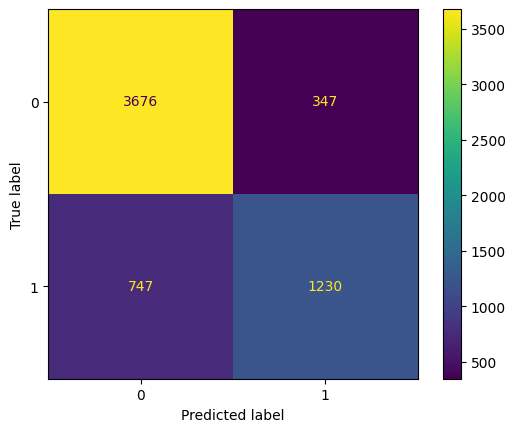

Accuracy 0.8176666666666667
AUROC 0.8698144495654792
Brier Score 0.1458063638709426
Area of Residual Graph 1461.304119513349
Maximum Deviation 29.6413812247552


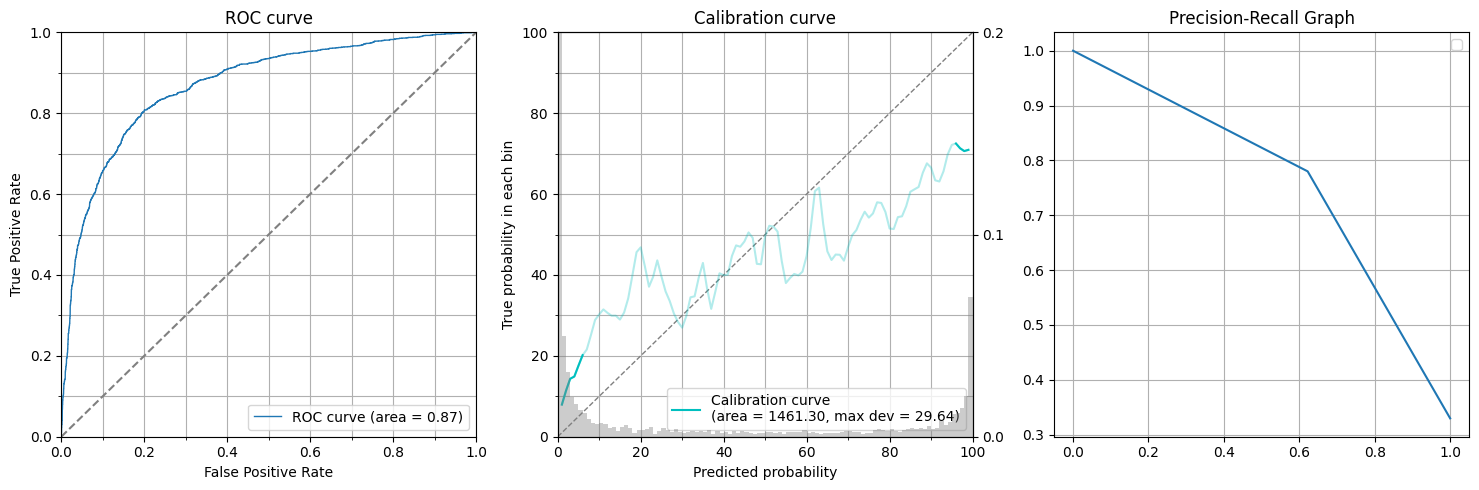

In [106]:
run(clf_abc_dt_ten,X_test,y_test) # ADA Boost Classifier

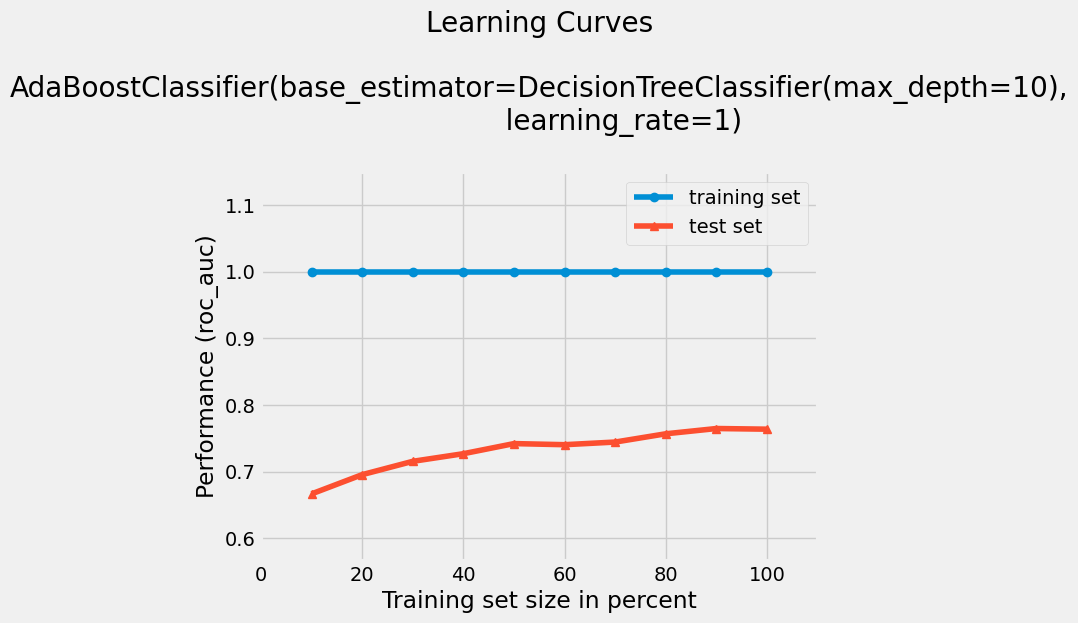

In [107]:
from mlxtend.plotting import plot_learning_curves
plot_learning_curves(X_train, y_train, X_test, y_test, clf_abc_dt_ten,scoring="roc_auc") #{'accuracy', 'average_precision', 'f1_micro', 'f1_macro', 'f1_weighted', 'f1_samples', 'log_loss', 'precision', 'recall', 'roc_auc', 'adjusted_rand_score', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'r2'}
plt.show()